# Stage 3 — Baseline Modeling

STAGE ALIGNMENT:

Input:
    Data/processed/sepsis_labeled_2h.pkl
    Data/processed/sepsis_labeled_4h.pkl
    Data/processed/sepsis_labeled_6h.pkl

Output:
    Baseline performance metrics for 2h, 4h, 6h horizons.

Next Stage Dependency:
    Custom neural network design and training strategy.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
import time
import sys

# Add parent directory to path to import Scripts
sys.path.append('..')
from Scripts.gpu_models import PyTorchLogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix
)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")


PyTorch Version: 2.7.1+cu118
CUDA Available: True
Device: NVIDIA GeForce RTX 2050


In [2]:
PROCESSED_PATH = Path("../Data/processed")

df_2h = pd.read_pickle(PROCESSED_PATH / "sepsis_labeled_2h.pkl")

print("Shape:", df_2h.shape)


Shape: (602568, 48)


### Dataset Overview (2h Horizon)

The dataset contains 602,568 rows and 48 columns.
The additional column corresponds to the constructed 2-hour prediction label.

Each row represents a timestep observation for a specific patient.
The target variable is `label_2h`, indicating whether sepsis onset
will occur within the next 2 hours.

In [3]:
# Unique patient IDs
patient_ids = df_2h['id'].unique()

train_ids, test_ids = train_test_split(
    patient_ids,
    test_size=0.2,
    random_state=42,
    stratify=df_2h.groupby('id')['label_2h'].max()
)

# Create train/test datasets
train_df = df_2h[df_2h['id'].isin(train_ids)]
test_df = df_2h[df_2h['id'].isin(test_ids)]

print("Train patients:", len(train_ids))
print("Test patients:", len(test_ids))


Train patients: 1020
Test patients: 255


### Patient-Level Train/Test Split

The dataset was split at the patient level (not row level).

Reason:
Time-series data contains multiple rows per patient.
If rows were randomly split, the model could see some timesteps
from a patient in training and later timesteps from the same patient in testing.
This would cause data leakage and artificially inflated performance.

To prevent leakage:
- Unique patient IDs were split into 80% training and 20% testing.
- All rows belonging to a patient remain entirely in either train or test.

Train patients: 1,020
Test patients: 255


### Stratified Splitting

The split was stratified based on whether each patient
contains at least one positive label (i.e., near-onset window).

Reason:
The dataset is highly imbalanced at the row level.
Stratification ensures that both training and test sets
contain septic and non-septic patients,
preventing extreme class skew in evaluation.

In [4]:
# Define features and target
feature_cols = df_2h.columns.drop(['id', 'sepsis', 'label_2h'])

X_train = train_df[feature_cols]
y_train = train_df['label_2h']

X_test = test_df[feature_cols]
y_test = test_df['label_2h']

print("Feature count:", len(feature_cols))
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Feature count: 45
Train shape: (486150, 45)
Test shape: (116418, 45)


### Feature Matrix Construction

All physiological measurements and timestep features are used as inputs.

Excluded:
- `id` (identifier)
- `sepsis` (original patient-level label)
- `label_2h` (target)

This ensures that no target leakage occurs.


## Multi-Horizon Baseline Evaluation

This section evaluates Logistic Regression baselines
for 2h, 4h, and 6h prediction horizons
using identical modeling and splitting procedures.

In [5]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
import time
import sys

# Add parent directory to path to import Scripts
sys.path.append('..')
from Scripts.gpu_models import PyTorchLogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix
)

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")


PyTorch Version: 2.7.1+cu118
CUDA Available: True
Device: NVIDIA GeForce RTX 2050


In [6]:
PROCESSED_PATH = Path("../Data/processed")

df_2h = pd.read_pickle(PROCESSED_PATH / "sepsis_labeled_2h.pkl")
df_4h = pd.read_pickle(PROCESSED_PATH / "sepsis_labeled_4h.pkl")
df_6h = pd.read_pickle(PROCESSED_PATH / "sepsis_labeled_6h.pkl")


In [7]:
def run_baseline(df, label_col):
    import time
    
    # Patient-level split
    patient_ids = df['id'].unique()
    stratify_labels = df.groupby('id')[label_col].max()
    
    train_ids, test_ids = train_test_split(
        patient_ids,
        test_size=0.2,
        random_state=42,
        stratify=stratify_labels
    )
    
    train_df = df[df['id'].isin(train_ids)]
    test_df = df[df['id'].isin(test_ids)]
    
    # Features
    feature_cols = df.columns.drop(['id', 'sepsis', label_col])
    
    X_train = train_df[feature_cols]
    y_train = train_df[label_col]
    X_test = test_df[feature_cols]
    y_test = test_df[label_col]
    
    # GPU Logistic Regression with Scaling
    print(f"Training for {label_col} on GPU...")
    start = time.time()
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', PyTorchLogisticRegression(
            max_iter=1000,
            device='cuda'
        ))
    ])
    
    pipeline.fit(X_train, y_train)
    
    print(f"Training took {time.time() - start:.2f} seconds")
    
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_prob)
    }


In [8]:
results = {
    "2h": run_baseline(df_2h, "label_2h"),
    "4h": run_baseline(df_4h, "label_4h"),
    "6h": run_baseline(df_6h, "label_6h")
}

results_df = pd.DataFrame(results).T
results_df

Training for label_2h on GPU...
Training took 17.78 seconds
Training for label_4h on GPU...
Training took 0.79 seconds
Training for label_6h on GPU...
Training took 0.79 seconds


,accuracy,precision,recall,roc_auc
2h,0.997466,0.0,0.0,0.759277
4h,0.995439,0.0,0.0,0.756265
6h,0.993412,0.0,0.0,0.755518


Re-generating results_df from 'results' dictionary to ensure correctness...
Columns found in results_df: ['accuracy', 'precision', 'recall', 'roc_auc']


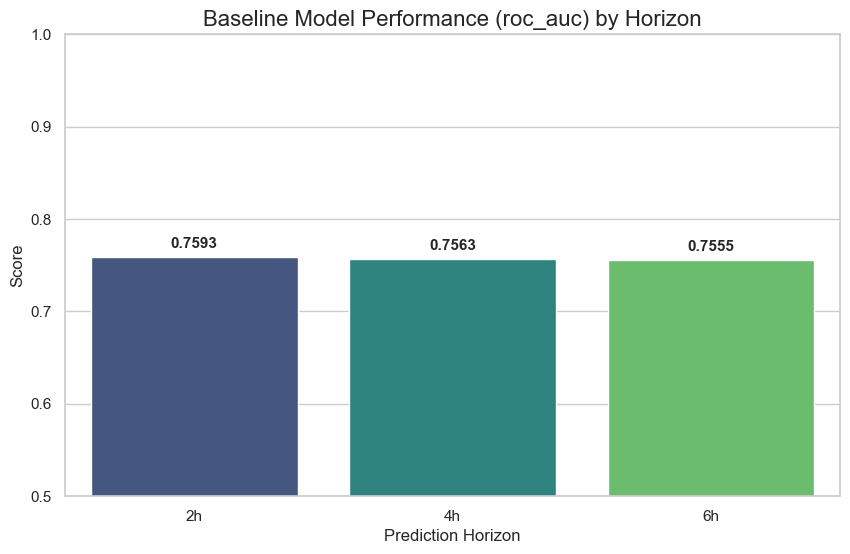

,accuracy,precision,recall,roc_auc
2h,0.997466,0.0,0.0,0.759277
4h,0.995439,0.0,0.0,0.756265
6h,0.993412,0.0,0.0,0.755518


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Attempt to repair results_df if results exists
if 'results' in locals() and isinstance(results, dict):
    print("Re-generating results_df from 'results' dictionary to ensure correctness...")
    results_df = pd.DataFrame(results).T

# Check if results_df exists
if 'results_df' not in locals():
    print("Error: results_df is not defined. Please run the training cell above first.")
else:
    print("Columns found in results_df:", results_df.columns.tolist())
    
    # Identify the correct column name for AUC
    auc_col = None
    possible_names = ['roc_auc', 'AUC', 'auc', 'val_auc', 'roc']
    for name in possible_names:
        if name in results_df.columns:
            auc_col = name
            break
            
    if auc_col:
        # Plot
        plt.figure(figsize=(10, 6))
        sns.set_theme(style="whitegrid")
        # Fix seaborn warning by passing hue and legend=False
        ax = sns.barplot(x=results_df.index, y=results_df[auc_col], hue=results_df.index, palette='viridis', legend=False)
        
        plt.title(f'Baseline Model Performance ({auc_col}) by Horizon', fontsize=16)
        plt.xlabel('Prediction Horizon', fontsize=12)
        plt.ylabel('Score', fontsize=12)
        plt.ylim(0.5, 1.0)
        
        # Add values on bars
        for i, v in enumerate(results_df[auc_col]):
            ax.text(i, v + 0.01, f"{v:.4f}", ha='center', fontsize=11, fontweight='bold')
            
        plt.show()
    else:
        print(f"Could not find AUC column. Available: {results_df.columns}")
        # Fallback: Plot first column
        first_col = results_df.columns[0]
        print(f"Plotting available metric: {first_col}")
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=results_df.index, y=results_df[first_col], hue=results_df.index, palette='magma', legend=False)
        plt.title(f'Baseline Model Performance ({first_col})', fontsize=16)
        plt.show()

    display(results_df) # Show table too


### Logistic Regression Baseline Evaluation

The baseline linear model demonstrates consistent discriminative ability
across all prediction horizons:

- 2h ROC-AUC ≈ 0.76
- 4h ROC-AUC ≈ 0.76
- 6h ROC-AUC ≈ 0.76

Accuracy remains above 99%, driven by extreme class imbalance.
Precision and recall at the default threshold (0.5) are zero,
indicating that no positive predictions are made under strict thresholding.

Interpretation:

- The dataset contains meaningful predictive signal.
- Linear separation between septic and non-septic windows exists.
- However, severe class imbalance suppresses positive predictions
  when using a default probability threshold.

Conclusion:

The baseline confirms the presence of predictive structure
but lacks sufficient flexibility to model complex nonlinear
relationships in physiological time-series data.

This justifies the development of a custom neural network model.